[베이스라인 코드](https://dacon.io/competitions/official/236336/codeshare) 참고


#### 질문사항

- train.csv를 `Assay ChEMBL ID`, `Fingerprint`, `IC50_nM` 세 colmun만 남도록 정리했는데, test.csv에는 ChEMBL ID 관련 column이 따로 없고 `Smiles`와 `IC50_nM`만 있어서 모델을 test.csv에 적용하기 어려울 것 같습니다.

- GMF를 돌려보려 하니 `ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).`가 발생하여 15번 셀과 같이 수정했는데, 확인을 부탁드리고 싶습니다.

# Import

In [9]:
!pip install rdkit

In [10]:
import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split

In [27]:
from rdkit.Chem import DataStructs

In [11]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

# Dataset: ChEMBL & Smiles

### DataLoad

In [37]:
# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        generator = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=CFG['NBITS'])
        fp = generator.GetFingerprint(mol)
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('/content/drive/MyDrive/DACON/제2회 신약개발 AI 경진대회/open/train.csv')
chembl_data.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


In [73]:
num_chembl = len(chembl_data['Assay ChEMBL ID'].unique())
num_smiles = len(chembl_data['Smiles'].unique())

print('Number of Assay ChEMBL IDs', num_chembl)
print('Number of Smiles', num_smiles)

Number of Assay ChEMBL IDs 72
Number of Smiles 1952


### Data Pre-processing

In [74]:
# smiles to fingerprint
dataset = chembl_data[['Assay ChEMBL ID', 'IC50_nM', 'Smiles']].copy()
dataset.loc[:, 'Fingerprint'] = dataset['Smiles'].apply(smiles_to_fingerprint)

# smiles 열 drop
dataset.drop('Smiles', axis=1, inplace=True)

# assay chembl id 정수 변환
dataset['Assay ChEMBL ID'] = dataset['Assay ChEMBL ID'].str.extract('(\d+)', expand=False).astype(int)

# 열 이름 변경 후 정렬
dataset.rename(columns={'Assay ChEMBL ID': 'chembl_id', 'Fingerprint': 'fp'}, inplace=True)
dataset = dataset[['chembl_id', 'fp', 'IC50_nM']]
dataset.head()

,chembl_id,fp,IC50_nM
0,4361896,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.022
1,4345131,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.026
2,4345131,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.078
3,4345131,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.081
4,4361896,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.099


In [75]:
train, test = train_test_split(dataset, test_size=0.2)

In [33]:
train.head()

,chembl_id,fp,IC50_nM
1474,921622,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",225.0
110,3887118,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.4
622,3887118,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",5.7
279,3887118,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.5
1545,3887963,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",361.0


In [34]:
test.head()

,chembl_id,fp,IC50_nM
839,3887118,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",10.0
1717,870864,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1000.0
321,3887118,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",2.8
165,3887118,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.8
1380,4359943,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",130.0


# Generalized Matrix Factorization (GMF)

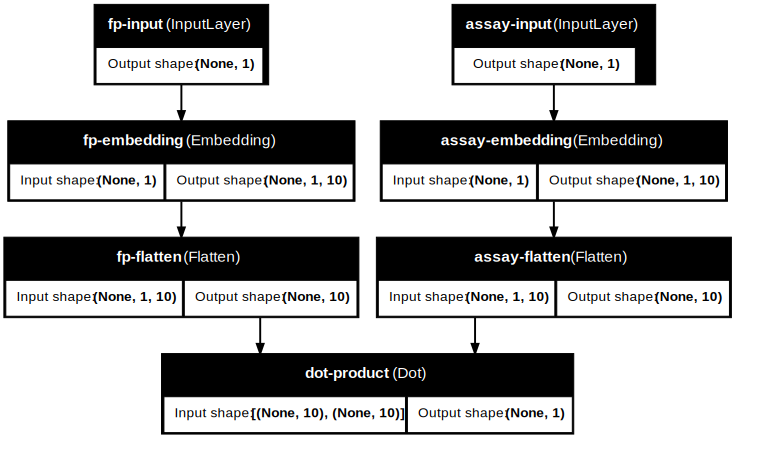

In [22]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dot
from keras.utils import model_to_dot
from IPython.display import SVG

# Let's use a higher latent dimension.
latent_dim = 10

fp_input = Input(shape=[1], name='fp-input')
fp_embedding = Embedding(num_smiles + 1, latent_dim, name='fp-embedding')(fp_input)
fp_vec = Flatten(name='fp-flatten')(fp_embedding)

assay_input = Input(shape=[1],name='assay-input')
assay_embedding = Embedding(num_chembl + 1, latent_dim, name='assay-embedding')(assay_input)
assay_vec = Flatten(name='assay-flatten')(assay_embedding)

prod = Dot(axes=1, name='dot-product')([fp_vec, assay_vec])

model = Model([assay_input, fp_input], prod)
model.compile('adam', 'mean_squared_error')

# Adjust DPI to reduce SVG size
dot = model_to_dot(model, show_shapes=True, dpi=70)

# Create SVG with adjusted size
svg = SVG(dot.create(prog='dot', format='svg'))

display(svg)

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ fp-input (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ assay-input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fp-embedding (Embedding)  │ (None, 1, 10)          │         19,530 │ fp-input[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ assay-embedding           │ (None, 1, 10)          │            730 │ assay-input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fp-flatten (Flatten)      │ (None, 10)             │              0 │ fp-embedding[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ assay-flatten (Flatten)   │ (None, 10)             │              0 │ assay-embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot-product (Dot)         │ (None, 1)              │              0 │ fp-flatten[0][0],      │
│                           │                        │                │ assay-flatten[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,260 (79.14 KB)

 Trainable params: 20,260 (79.14 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
chembl_id_to_num = {id: i for i, id in enumerate(dataset['chembl_id'])}
dataset['chembl_id'] = dataset['chembl_id'].map(chembl_id_to_num).astype(np.int32)

In [82]:
X_train_fp = np.stack(train['fp'].values).astype(np.float32)
X_test_fp = np.stack(test['fp'].values).astype(np.float32)
X_train_chembl_id = train['chembl_id'].values.reshape(-1, 1).astype(np.int32)
X_test_chembl_id = test['chembl_id'].values.reshape(-1, 1).astype(np.int32)
y_train = train['IC50_nM'].values.astype(np.float32)
y_test = test['IC50_nM'].values.astype(np.float32)

In [78]:
from keras.layers import Dense, Concatenate
from tensorflow.keras.utils import plot_model

In [87]:
# 크기 확인
print("train.chembl_id 크기:", X_train_chembl_id.shape)
print("train.fp 크기:", X_train_fp.shape)
print("test.chembl_id 크기:", X_test_chembl_id.shape)
print("test.fp 크기:", X_test_fp.shape)
print("train.IC50_nM 크기:", y_train.shape)
print("test.IC50_nM 크기:", y_test.shape)

# chembl_id 값의 범위 확인
print("chembl_id 최대 값:", X_train_chembl_id.max())
print("chembl_id 최소 값:", X_train_chembl_id.min())

# 임베딩 인덱스 범위 확인
max_index = len(chembl_id_to_num)
print(f"임베딩 인덱스 범위: 0 ~ {max_index}")

train.chembl_id 크기: (1561, 1)
train.fp 크기: (1561, 2048)
test.chembl_id 크기: (391, 1)
test.fp 크기: (391, 2048)
train.IC50_nM 크기: (1561,)
test.IC50_nM 크기: (391,)
chembl_id 최대 값: 5262917
chembl_id 최소 값: 870864
임베딩 인덱스 범위: 0 ~ 72


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ chembl_id (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fingerprint (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ chembl_id_embedding       │ (None, 1, 10)          │            720 │ chembl_id[0][0]        │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 10)             │         20,490 │ fingerprint[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ chembl_id_flatten         │ (None, 10)             │              0 │ chembl_id_embedding[0… │
│ (Flatten)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot-product (Dot)         │ (None, 1)              │              0 │ dense_9[0][0],         │
│                           │                        │                │ chembl_id_flatten[0][… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,210 (82.85 KB)

 Trainable params: 21,210 (82.85 KB)

 Non-trainable params: 0 (0.00 B)

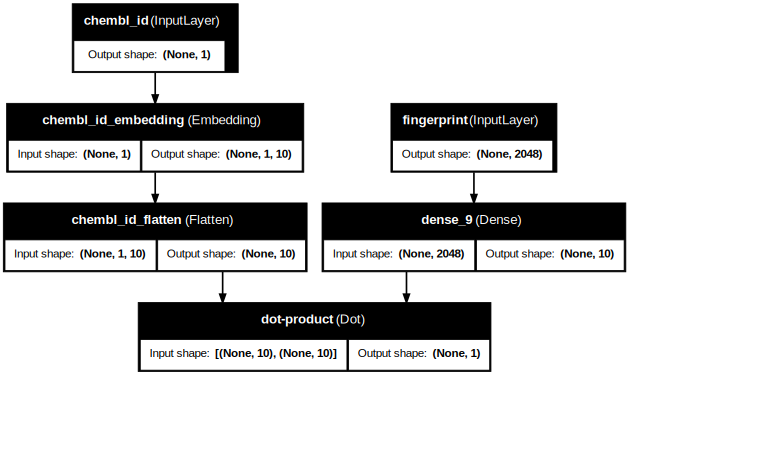

In [89]:
latent_dim = 10  # 임베딩 차원

# 입력 정의
input_fp = Input(shape=(CFG['NBITS'],), name='fingerprint')
input_chembl_id = Input(shape=(1,), name='chembl_id')

# chembl_id 임베딩
chembl_id_embedding = Embedding(input_dim=len(chembl_id_to_num), output_dim=latent_dim, name='chembl_id_embedding')(input_chembl_id)
chembl_id_vec = Flatten(name='chembl_id_flatten')(chembl_id_embedding)

# fp 처리 (이미 고차원 벡터이므로 추가 처리는 필요 없음)
fp_dense = Dense(latent_dim, activation='relu')(input_fp)  # latent_dim 크기로 변환

# 두 입력의 내적 계산
dot_product = Dot(axes=1, name='dot-product')([fp_dense, chembl_id_vec])

# 모델 정의
model = Model(inputs=[input_fp, input_chembl_id], outputs=dot_product)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약
model.summary()

# 모델 시각화
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(model, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

In [90]:
# 모델 훈련
history = model.fit(
    [X_train_fp, X_train_chembl_id], y_train,
    epochs=10, validation_data=([X_test_fp, X_test_chembl_id], y_test)
)

# 학습 결과 시각화
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# 예측 및 평가
y_hat = np.round(model.predict([X_test_fp, X_test_chembl_id]), decimals=2)
y_true = y_test
mae = mean_absolute_error(y_true, y_hat)
print(f'Mean Absolute Error: {mae}')

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node functional_8_1/chembl_id_embedding_1/GatherV2 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-90-15727780cf3f>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 140, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 4875, in take

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1951, in take

indices[0,0] = 921622 is not in [0, 72)
	 [[{{node functional_8_1/chembl_id_embedding_1/GatherV2}}]] [Op:__inference_one_step_on_iterator_10128]

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 160942686208.0000 - val_loss: 88470536192.0000
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 70215376896.0000 - val_loss: 31032903680.0000
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22296903680.0000 - val_loss: 5979363840.0000
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3703857408.0000 - val_loss: 436415104.0000
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 219296096.0000 - val_loss: 23938980.0000
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6625359.5000 - val_loss: 16864630.0000
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4613015.0000 - val_loss: 16874568.0000
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3952515.0000 - val_loss: 16873652.0000
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3861381.0000 - val_loss: 16867352.0000
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3592230.2500 - val_loss: 16869018.0000


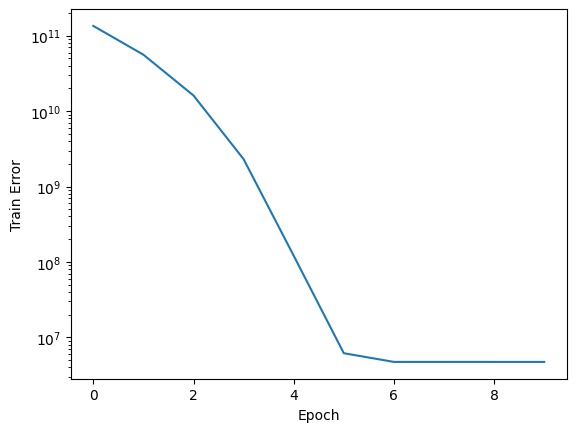

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Absolute Error: 1073.0531005859375


In [91]:
# 입력 정의
input_fp = Input(shape=(CFG['NBITS'],), name='fingerprint')
input_chembl_id = Input(shape=(1,), name='chembl_id')

# Fingerprint 처리
fp_layer = Dense(64, activation='relu')(input_fp)

# chembl_id 처리
chembl_id_layer = Dense(4, activation='relu')(input_chembl_id)

# 두 입력을 결합
merged = Concatenate()([fp_layer, chembl_id_layer])
output = Dense(1)(merged)

# 모델 정의
model = Model(inputs=[input_fp, input_chembl_id], outputs=output)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
history = model.fit(
    [X_train_fp, X_train_chembl_id], y_train,
    epochs=10, validation_data=([X_test_fp, X_test_chembl_id], y_test)
)

# 학습 결과 시각화
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# 예측 및 평가
y_hat = np.round(model.predict([X_test_fp, X_test_chembl_id]), decimals=2)
y_true = y_test
mae = mean_absolute_error(y_true, y_hat)
print(f'Mean Absolute Error: {mae}')

# Evaluation & Submission

In [65]:
"""def pIC50_to_IC50(pic50_values):
    return 10 ** (9 - pic50_values)

# Validation 데이터로부터의 학습 모델 평가
val_y_pred = model.predict(val_x)
mse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred))
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')"""

"def pIC50_to_IC50(pic50_values):\n    return 10 ** (9 - pic50_values)\n\n# Validation 데이터로부터의 학습 모델 평가\nval_y_pred = model.predict(val_x)\nmse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred))\nrmse = np.sqrt(mse)\n\nprint(f'RMSE: {rmse}')"

### Inference

In [ ]:
"""test = pd.read_csv('./test.csv')
test['Fingerprint'] = test['Smiles'].apply(smiles_to_fingerprint)

test_x = np.stack(test['Fingerprint'].values)

test_y_pred = model.predict(test_x)"""

### Submission

In [ ]:
"""submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()"""

In [ ]:
"""submit.to_csv('./baseline_submit.csv', index=False)"""